# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [31]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [32]:
try:
    df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26


Признаки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen` являются избыточными, удалим их

In [33]:
df.drop(columns = ['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1, inplace=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19


In [34]:
df.isna().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
dtype: float64

Пропуски в категориальных признаках `NotRepaired`, `VehicleType`, `FuelType`, `Gearbox`, `Model` заменим на `unknown`

In [35]:
df.fillna('unknown', inplace=True)
df.isna().mean().sort_values(ascending=False)

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
dtype: float64

<AxesSubplot:>

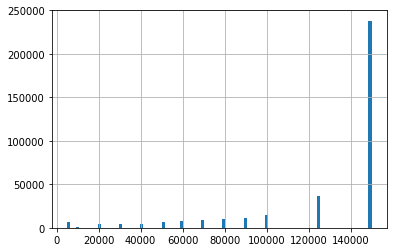

In [36]:
df.Kilometer.hist(bins=100)

В признаке `Kilometer` аномалий нет, с ним можно работать

<AxesSubplot:>

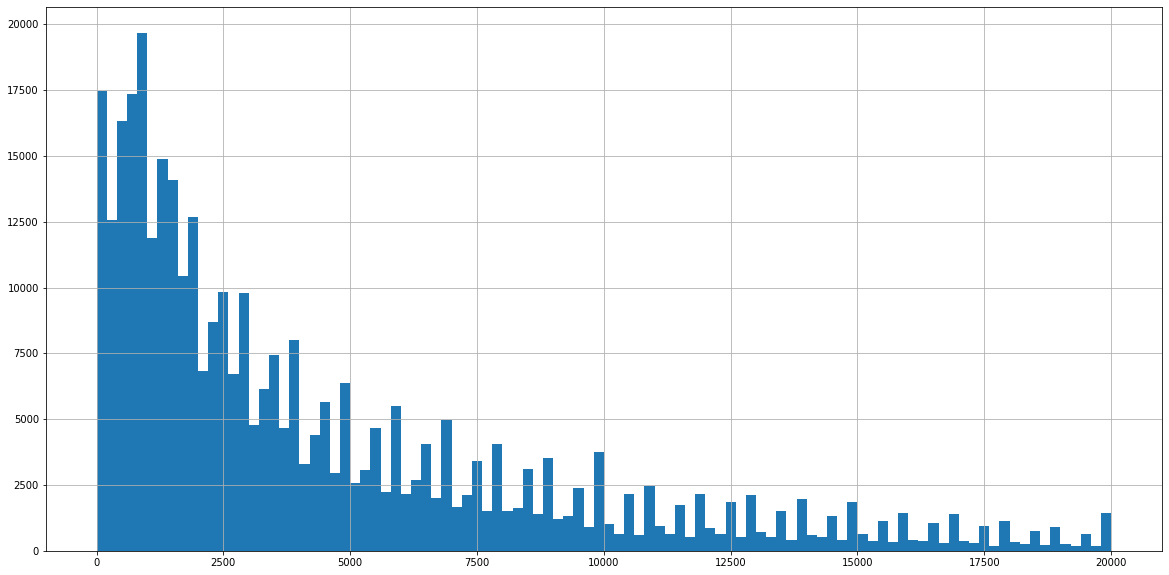

In [37]:
df.Price.hist(figsize = (20, 10), bins=100)              

Строки с нулевым значением цены есть смысл удалить, т.к. они могут исказить результаты обучения модели

<AxesSubplot:>

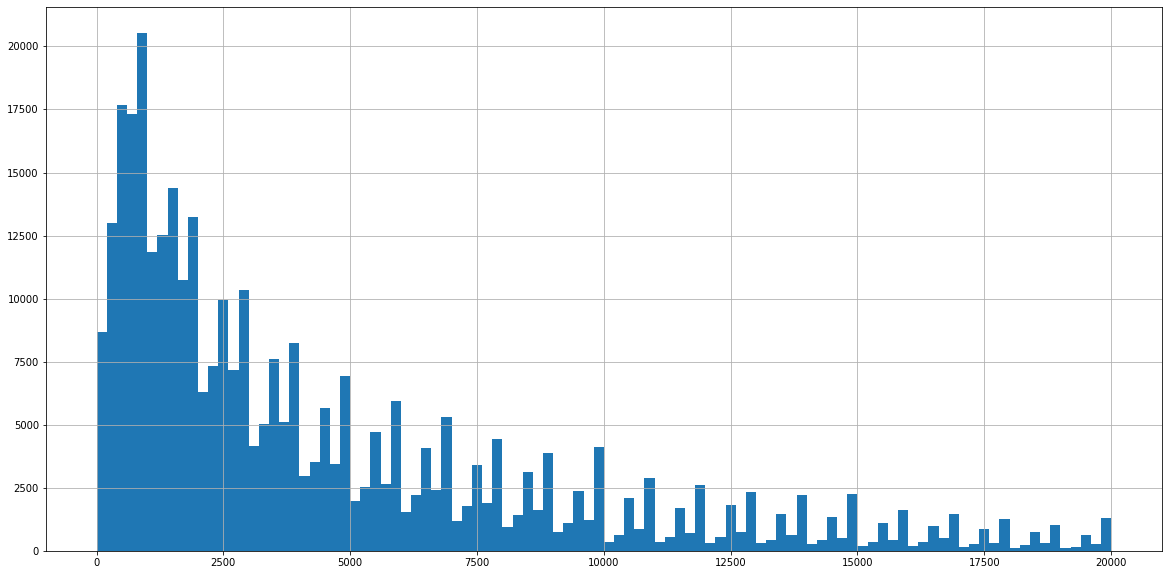

In [38]:
df = df[df.Price > 0]
df.Price.hist(figsize = (20, 10), bins=100)

<AxesSubplot:>

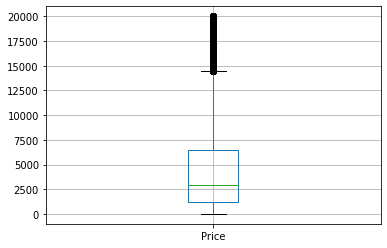

In [39]:
df.boxplot('Price')

Больших выбросов по целевому признаку `Price` нет, больше ничего не будем удалять

/tmp/ipykernel_31/822728949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateCreated_year'] = pd.DatetimeIndex(df['DateCreated']).year


<AxesSubplot:>

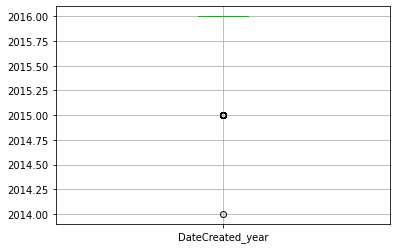

In [40]:
df['DateCreated_year'] = pd.DatetimeIndex(df['DateCreated']).year
df.boxplot('DateCreated_year')

In [41]:
df['DateCreated_year'].value_counts()

2016    343571
2015        25
2014         1
Name: DateCreated_year, dtype: int64

Видно, что подавляющее количество объявлений за 2016 г. Строки с объявлениями за 2014 и 2015 удалим, чтобы не искажать выводы.

In [42]:
df = df[df.DateCreated_year == 2016]
display(df['DateCreated_year'].value_counts())

2016    343571
Name: DateCreated_year, dtype: int64

In [43]:
#Удалим за ненадобностью колонки DateCreated и DateCreated_year
df.drop(columns = ['DateCreated', 'DateCreated_year'], axis = 1, inplace=True)

<AxesSubplot:>

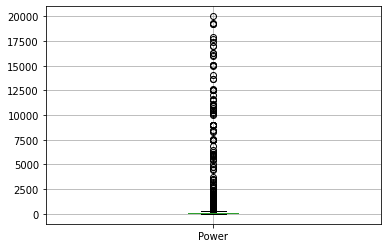

In [44]:
df.boxplot('Power')

<AxesSubplot:>

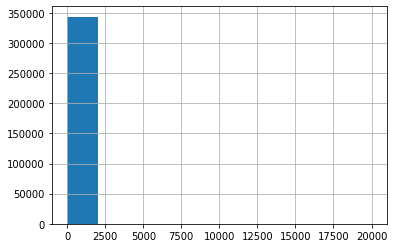

In [45]:
df['Power'].hist()

Видно, что в в значениях мощности есть выбросы. Ограничим  `0 < Power < 600`

<AxesSubplot:>

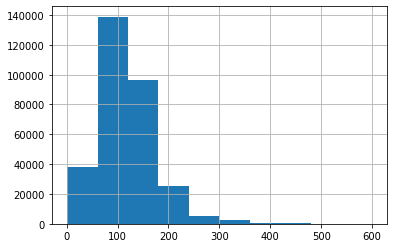

In [46]:
df = df[(df['Power'] > 0) & (df['Power'] < 600)]
df['Power'].hist()

In [47]:
df.RegistrationMonth.value_counts()

3     31351
6     28481
4     26606
5     26407
7     24587
10    23615
12    21910
11    21715
9     21553
1     20793
8     20351
0     20067
2     19407
Name: RegistrationMonth, dtype: int64

In [48]:
df = df[df.RegistrationMonth != 0]
df.RegistrationMonth.value_counts()

3     31351
6     28481
4     26606
5     26407
7     24587
10    23615
12    21910
11    21715
9     21553
1     20793
8     20351
2     19407
Name: RegistrationMonth, dtype: int64

## Обучение моделей

In [49]:
#Кодируем категориальные признаки методом  Ordinal Encoding 
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.fit_transform(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,227.0,125000,5,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,7.0,2016,0.0,150,4.0,150000,12,7.0,0.0,0.0
354362,3200,4.0,2004,1.0,225,140.0,150000,5,6.0,30.0,2.0
354366,1199,1.0,2000,0.0,101,106.0,125000,3,6.0,32.0,0.0
354367,9200,0.0,1996,1.0,102,223.0,150000,3,2.0,38.0,0.0


In [50]:
features = df.drop('Price', axis = 1)
target = df['Price']
features_train, features_test, target_train, target_test = (
    train_test_split(features, target, test_size=0.2, random_state=12345)
)
len(features_train), len(features_test)

(229420, 57356)

In [51]:
#Подбор лучшей модели для линейной регрессии
model_lr = LinearRegression()
model_lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [52]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model_lr, parameters, cv=5,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_lr = grid.best_estimator_
print(f'Лучшие параметры линейной регрессии {grid.best_params_}')
print(f'Лучший rmse линейной регрессии {grid.best_score_ * (-1):.2f}')

Лучшие параметры линейной регрессии {'copy_X': True, 'fit_intercept': False, 'normalize': True}
Лучший rmse линейной регрессии 3099.60


In [53]:
#Дерево решений - подбор модели
model_dt = DecisionTreeRegressor()
model_dt.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [54]:
parameters = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10], 
    "min_samples_split": [10, 20, 40], 
    "min_samples_split": [10, 20, 40], 
    "max_leaf_nodes": [5, 20, 100]
}
grid = GridSearchCV(model_dt, parameters, cv=5,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_dt = grid.best_estimator_
print(f'Лучшие параметры дерева решений {grid.best_params_}')
print(f'Лучший rmse дерева решений {grid.best_score_ * (-1):.2f}')

Лучшие параметры дерева решений {'max_depth': 9, 'max_leaf_nodes': 100, 'min_samples_split': 10}
Лучший rmse дерева решений 2201.53


In [55]:
#Случайный лес - подбор модели
model_rf = RandomForestRegressor()
model_rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [56]:
%%time
parameters = { 
    "n_estimators"      : [10, 100],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2],
    "max_depth": [None, 1, 2, 3],
    "bootstrap": [True, False],
    } 
grid = GridSearchCV(model_rf, parameters, cv=5,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_rf = grid.best_estimator_
print(f'Лучшие параметры модели случайного леса {grid.best_params_}')
print(f'Лучший rmse модели случайного леса  {grid.best_score_ * (-1):.2f}')

Лучшие параметры модели случайного леса {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Лучший rmse модели случайного леса  1586.07
CPU times: user 31min 6s, sys: 5.47 s, total: 31min 11s
Wall time: 31min 12s


In [57]:
#LGBM - подбор модели
model_LightGBM = lgb.LGBMRegressor()
model_LightGBM.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [58]:
%%time
parameters = { 
    'num_leaves': [7, 14, 21, 28],
    'learning_rate': [0.1, 0.03],
    'max_depth': [-1, 3],
    'n_estimators': [50, 100, 200],
    } 
grid = GridSearchCV(model_LightGBM, parameters, cv=5,
                    scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
model_LightGBM = grid.best_estimator_
print(f'Лучшие параметры модели LGBM {grid.best_params_}')
print(f'Лучший rmse модели LGBM  {grid.best_score_ * (-1):.2f}')

Лучшие параметры модели LGBM {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28}
Лучший rmse модели LGBM  1670.17
CPU times: user 1h 20min 49s, sys: 43.8 s, total: 1h 21min 33s
Wall time: 1h 22min 4s


## Анализ моделей

### Замер времени обучения и времени предсказания на обучающей выборке


In [59]:
%%time
#Линейная регрессия
model_lr.fit(features_train, target_train)

CPU times: user 52.1 ms, sys: 15.6 ms, total: 67.7 ms
Wall time: 84.7 ms


LinearRegression(fit_intercept=False, normalize=True)

In [60]:
%%time
predictions = model_lr.predict(features_train)
#rmse = mean_squared_error(target_test, predictions, squared=False)
#print("RMSE: %.2f" % rmse)

CPU times: user 37.4 ms, sys: 70.8 ms, total: 108 ms
Wall time: 101 ms


In [61]:
%%time
#Дерево решений
model_dt.fit(features_train, target_train)

CPU times: user 388 ms, sys: 37 µs, total: 388 ms
Wall time: 391 ms


DecisionTreeRegressor(max_depth=9, max_leaf_nodes=100, min_samples_split=10)

In [62]:
%%time
predictions = model_dt.predict(features_train)
#rmse = mean_squared_error(target_test, predictions, squared=False)
#print("RMSE: %.2f" % rmse)

CPU times: user 24 ms, sys: 36 µs, total: 24 ms
Wall time: 21.6 ms


In [63]:
%%time
#Случайный лес
model_rf.fit(features_train, target_train)

CPU times: user 29.1 s, sys: 24.7 ms, total: 29.1 s
Wall time: 29.1 s


RandomForestRegressor(max_features='log2')

In [64]:
%%time
predictions = model_rf.predict(features_train)
#rmse = mean_squared_error(target_test, predictions, squared=False)
#print("RMSE: %.2f" % rmse)

CPU times: user 10.7 s, sys: 5.77 ms, total: 10.7 s
Wall time: 10.7 s


In [65]:
%%time
#LGBM
model_LightGBM.fit(features_train, target_train)

CPU times: user 9min 58s, sys: 5.98 s, total: 10min 4s
Wall time: 10min 8s


LGBMRegressor(n_estimators=200, num_leaves=28)

In [66]:
%%time
predictions = model_LightGBM.predict(features_train)
#rmse = mean_squared_error(target_test, predictions, squared=False)
#print("RMSE: %.2f" % rmse)

CPU times: user 2.83 s, sys: 4.92 ms, total: 2.83 s
Wall time: 2.83 s


### Сравнение моделей на обучающей выборке

№ | Модель | Гиперпараметры | RMSE | Время обучения, сек. | Время предсказания, сек. 
---:|:---|:---:|:---:|:---:| ---
1 | **Линейная регрессия** | {'copy_X': True, 'fit_intercept': False, 'normalize': True} | 3099.60 | 84.7 ms | 101 ms
2 | **Дерево решений** | {'max_depth': 9, 'max_leaf_nodes': 100, 'min_samples_split': 10} | 2201.53 | 391 ms | 21.6 ms
3 | **Случайный лес** |  {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100} | 1586.07 | 29.1 s| 10.7 s
4 | **LGBM** | {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 28} | 1670.17 | 10min 8s | 2.83 s


Провели анализ четырех разных моделей с подбором гиперпараметов через GridSearchCV и сравнение по метрике RMSE и по времени обучения. Можно сделать следующие выводы:
- Самую низкую ошибку RMSE 1586.07 (самая качественная модель) дает модель на основе случайного леса, самая высокая RMSE 3099.60 у модели на основе линейной регрессии . 
- Наименьшее время обучения у модели на основе линейной регрессии (84.7 ms), наибольшее - у LGBM (10min 8s)

Итак, самая лучшая модель - Случайный лес. Проверим ее на тестовой выборке

In [68]:
%%time
predictions = model_rf.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print("RMSE: %.2f" % rmse)

RMSE: 1580.30
CPU times: user 2.54 s, sys: 404 µs, total: 2.54 s
Wall time: 2.54 s


RMSE модели случайного леса на тестовой выборке составила 1580.30, скорость предсказания - 2.54 s